In [1]:
import os
from dotenv import load_dotenv
from datasets import load_dataset, DatasetDict
import matplotlib.pyplot as plt

#### Setting up some constants (loading from .env file)

In [2]:
load_dotenv()

SEED = int(os.getenv('SEED'))
DATASET_HUGGINGFACE_NAME = os.getenv('DATASET_HUGGINGFACE_NAME')
LOCAL_DATASET_PATH = os.getenv('LOCAL_DATASET_PATH')

#### Loading the data from Hugging Face
As we can see, the data is already split into training and test sets.  
It has 2 columns: `tokens` and `tags`, where `tokens` is a list of words and `tags` is a list of tag-ids for each word (0 - non mountain, 1 - mountain).

In [3]:
raw_ds = load_dataset(DATASET_HUGGINGFACE_NAME)
raw_ds

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 88619
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 22110
    })
})

In [11]:
print(raw_ds['train'][0]['tokens'][20:30])
print(raw_ds['train'][0]['tags'][20:30])

['Fugaku', 'was', 'unveiled;', 'it', 'depicts', 'Mount', 'Fuji,', 'symbolising', "Fugaku's", 'high']
[0, 0, 0, 0, 0, 1, 1, 0, 0, 0]


In [9]:
def mountains_distribution(ds):
    '''
    Function to calculate the distribution of mountains in the dataset
    
    Args:
        ds (datasets.Dataset): dataset to calculate the distribution

    Returns:
        total_mountains (int): total number of mountains in the dataset
        total_tokens (int): total number of tokens in the dataset
        sentences_with_mountains (int): total number of sentences with mountains in the dataset
        sentence_without_mountains (int): total number of sentences without mountains in the dataset
    '''
    total_tokens = 0
    total_mountains = 0
    sentences_with_mountains = 0
    for sentence in ds:
        total_tokens += len(sentence['tags'])
        if 1 in sentence['tags']:
            total_mountains += sentence['tags'].count(1)
            sentences_with_mountains += 1
    sentence_without_mountains = len(ds) - sentences_with_mountains
    return total_mountains, total_tokens, sentences_with_mountains, sentence_without_mountains

train_total_mountains, train_total_tokens, train_sentences_with_mountains, train_sentence_without_mountains = mountains_distribution(raw_ds['train'])
test_total_mountains, test_total_tokens, test_sentences_with_mountains, test_sentence_without_mountains = mountains_distribution(raw_ds['test'])

In [21]:
print(f'Train dataset: {train_sentences_with_mountains} sentences containing mountains and {train_sentence_without_mountains} sentences without mountains')
print(f'Test dataset: {test_sentences_with_mountains} sentences containing mountains and {test_sentence_without_mountains} sentences without mountains')
print(f'Train dataset: {train_total_mountains/train_total_tokens:.2%} of tokens are mountains')
print(f'Test dataset: {test_total_mountains/test_total_tokens:.2%} of tokens are mountains')

Train dataset: 88223 sentences containing mountains and 396 sentences without mountains
Test dataset: 22003 sentences containing mountains and 107 sentences without mountains
Train dataset: 4.15% of tokens are mountains
Test dataset: 4.16% of tokens are mountains


#### Spliting tokens with word->punctiation into two tokens
Reason: The data itself is quite clean, but when I was testing the model I noticed, that because words and punctuation are not separated in the data and they share the same tag (that propagates onto punctuation during tokenization), the model predicted punctuation after mountain names as mountain names.  

In [12]:
def split_tokens_with_punctuations(example):
    '''
    Split tokens with punctuations into two tokens.

    Args:
        example (dict): A dictionary containing tokens and tags.

    Returns:
        dict: A dictionary containing tokens and tags with punctuations split.
    '''
    new_tokens = []
    new_labels = []
    for token, label in zip(example['tokens'], example['tags']):
        if token.endswith(('!', '?', '.', ',')) and len(token) > 1:
            new_tokens.append(token[:-1])
            new_tokens.append(token[-1])
            new_labels.append(label)
            new_labels.append(0) # 0 is the tag-id for non-entity
        else:
            new_tokens.append(token)
            new_labels.append(label)
    return {'tokens': new_tokens, 'tags': new_labels}

In [13]:
raw_ds = raw_ds.map(split_tokens_with_punctuations)

Map: 100%|██████████| 22110/22110 [00:02<00:00, 8563.17 examples/s]


#### Considering that BERT has a maximum input length of 512 tokens, we will remove examples that are too long.
There should not be a lot samples that are longer than 400 tokens, so we will remove them (besides, further subword tokenization will make them even longer).

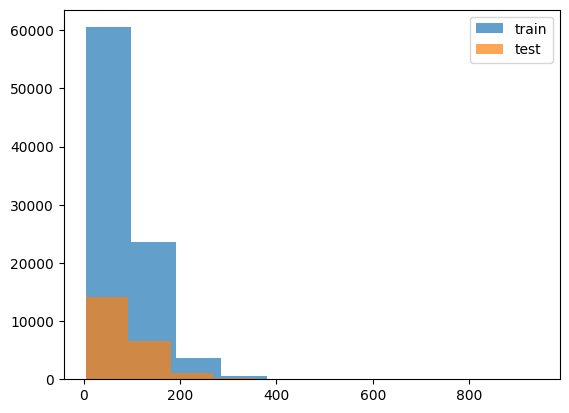

In [15]:
lengths_train = [len(example['tokens']) for example in raw_ds['train']]
lengths_test = [len(example['tokens']) for example in raw_ds['test']]

plt.hist(lengths_train, alpha=0.7, label='train')
plt.hist(lengths_test, alpha=0.7, label='test')
plt.legend()
plt.show()

In [16]:
raw_ds = raw_ds.filter(lambda x: len(x['tokens']) <= 400)
raw_ds

Filter: 100%|██████████| 22110/22110 [00:01<00:00, 12922.01 examples/s]


DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 88458
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 22076
    })
})

#### Next, we will divide the data into training, validation and testing sets
To reduce training time I decided to take 30000 samples for training, 10000 for validation and 10000 for testing.

In [21]:
ds_train_40000 = raw_ds['train'].train_test_split(test_size=40000, seed=SEED)['test']
train_val = ds_train_40000.train_test_split(test_size=10000, seed=SEED)
train = train_val['train']
val = train_val['test']
test = raw_ds['test'].train_test_split(test_size=10000, seed=SEED)['test']

new_ds = DatasetDict({'train': train, 'val': val, 'test': test})
new_ds

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 30000
    })
    val: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
})

#### Splitting consecutive entity tokens into B and I tokens

In [57]:
def add_inside_tags(tags):
    '''
    Add inside tags for the tags.

    Args:
        tags (list): A list of tags.

    Returns:
        list: A list of tags with inside tags added.
    '''
    new_tags = []
    prev = 0
    for tag in tags:
        if tag == 0:
            new_tags.append(tag)
            prev = 0
        elif tag == 1 and prev == 0:
            new_tags.append(1)
            prev = 1
        else:
            new_tags.append(2)

    return new_tags


new_ds = new_ds.map(lambda x: {'tags': add_inside_tags(x['tags'])})

Map: 100%|██████████| 10000/10000 [00:00<00:00, 15430.58 examples/s]


In [58]:
print(new_ds['train'][0]['tokens'][0:15])
print(new_ds['train'][0]['tags'][0:15])

['On', 'average', ',', 'Blue', 'Mountain', 'sells', 'more', 'than', '750,000', 'lift', 'tickets', 'per', 'year', ',', 'making']
[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### Saving obtained data

In [62]:
new_ds.save_to_disk(LOCAL_DATASET_PATH)

Saving the dataset (1/1 shards): 100%|██████████| 10000/10000 [00:00<00:00, 909452.50 examples/s] 
